## Plot Attention Weights

Script used for generating plots in the report.

In [1]:
%cd ~/cil-text-classification/ 

/cluster/home/rarade/cil-text-classification


In [2]:
import re
import numpy as np
import pandas as pd
from tqdm import tqdm_notebook as tqdm
from matplotlib import pyplot as plt
import matplotlib.colors as colors

import torch
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler
from transformers import RobertaForSequenceClassification

import pytorch_lightning as pl
from pytorch_lightning import Trainer

from core.data.io import *
from core.data.datasets import *
from core.data.tokenizers import *
from core.data.definitions import *
from core.utils.lime_utils import *
from core.utils.helper import *

In [3]:
EXPERIMENT_PATH = '/cluster/scratch/rarade/roberta-25-06-2020/'

model = load_model_from_experiment(EXPERIMENT_PATH)

Loading model  roberta-base


In [4]:
train, _ = load_datasets('in', full=model.hparams.full, clean=True)

val_preds = pd.read_csv(EXPERIMENT_PATH+'/val_with_logits.csv')
val_preds[ID_COL] = val_preds[ID_COL] - 1
# val_preds.sort_values(ID_COL, inplace=True)
val_preds.set_index(ID_COL, inplace=True)

val = train.iloc[val_preds.index]
del train

val[OUT_COL] = val[OUT_COL].apply(lambda x: -1 if x == 0 else 1)
print ('Validation accuracy: {}'\
       .format(np.sum(val.loc[val_preds.index, OUT_COL]==val_preds.loc[val_preds.index, 'Prediction'])/val_preds.shape[0]))

val_preds.head()

Validation accuracy: 0.90936


,Prediction,NegativeLogits,PositiveLogits
Id,,,
1812203,-1,4.028181,-3.644433
567831,1,-2.055248,2.570960
2480609,1,-0.939021,1.452965
746673,-1,4.020282,-3.616997
1429954,1,-0.802497,1.243536


In [5]:
val_input_ids, val_attn_mask = transformer_tokenize(val[IN_COL].values, model.tokenizer, 
                                                    max_seq_length=model.max_seq_length)

val_dataset = TransformerTestDataset(val_input_ids, val_attn_mask, val)
val_dataloader = DataLoader(dataset=val_dataset, sampler=SequentialSampler(val_dataset), 
                            batch_size=model.hparams.batch_size_validation, num_workers=model.hparams.workers)

Tokenizing text ... 
Tokenization completed!


In [6]:
mod = RobertaForSequenceClassification.from_pretrained('roberta-base', num_labels=2, output_attentions=True)
mod.load_state_dict(model.model.state_dict())
mod.eval()
tokenizer = model.tokenizer

del model
model = mod
del mod

In [7]:
for batch in val_dataloader:
    input_ids, input_mask, ids = batch
    out = model(input_ids, token_type_ids=None, attention_mask=input_mask, labels=None)
    attns = out[-1]
    break

### Plot All Attention Heads

In [8]:
NUM_LAYERS = 12
NUM_HEADS = 12

def plot_all_heads(attns, ind=0):
    plt.figure(figsize=(8, 8))
    print ('Text: ', tokenizer.decode(input_ids[ind]))
    
    num_word = torch.sum(input_ids[ind]!=1).numpy()
    for i in range(NUM_LAYERS):
        for j in range(NUM_HEADS):
            attn = np.moveaxis(attns[i][ind].detach().numpy(), 0, -1)[:, :, j]
            attn = attn[:num_word, :num_word]
            plt.subplot(12, 12, i*12+j+1)
            plt.imshow(attn, cmap='Blues', interpolation='none')
            ax = plt.gca()
            plt.box(False)
            ax.set_xticks([])
            ax.set_yticks([])

def plot_max_heads(attns, ind=0):
    plt.figure(figsize=(16, 5))
    print ('Text: ', tokenizer.decode(input_ids[ind]))
    
    num_word = torch.sum(input_ids[ind]!=1).numpy()
    for i in range(NUM_LAYERS):
        attn = np.moveaxis(attns[i][ind].detach().numpy(), 0, -1)
        attn = np.max(attn, axis=-1)
        attn = attn[:num_word, :num_word]
        plt.subplot(2, 6, i+1)
        plt.imshow(attn, cmap='Blues', interpolation='none')
        ax = plt.gca()
        ax.set_title('Layer {}'.format(i+1))
        ax.set_xticks([])
        ax.set_yticks([])

Text:  <s> < user > today is my birthday so could u tweet something to me? it would make my day! xx</s><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad>


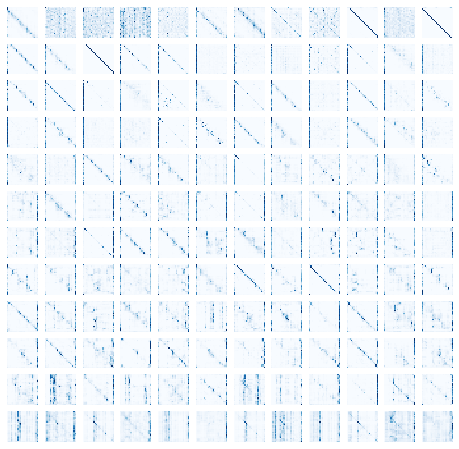

In [9]:
plot_all_heads(attns, 1)

This only considers the maximum of all the attention heads.

Text:  <s> < user > today is my birthday so could u tweet something to me? it would make my day! xx</s><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad>


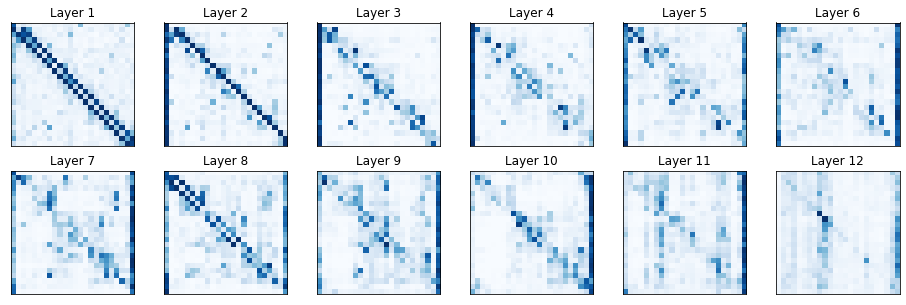

In [10]:
plot_max_heads(attns, 1)

### Plot Attention Heads for a Particular Layer

Text:  <s> < user > today is my birthday so could u tweet something to me? it would make my day! xx </s>


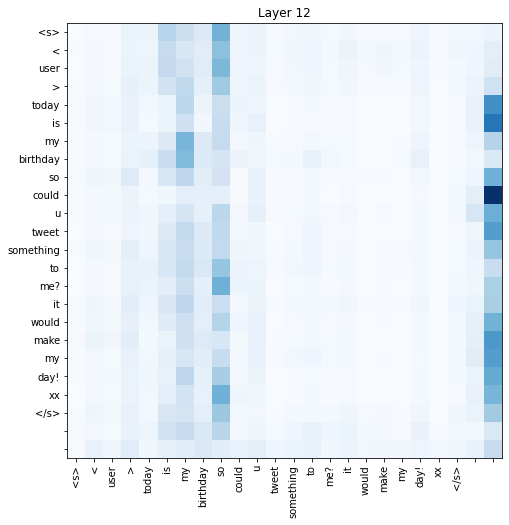

In [11]:
def plot_layer_head(attns, ind=0, layer=0, head=0):
    plt.figure(figsize=(8, 8))
    text = tokenizer.decode(input_ids[ind])
    
    num_word = torch.sum(input_ids[ind]!=1).numpy()
    attn = np.moveaxis(attns[layer][ind].detach().numpy(), 0, -1)[:, :, head]
    attn = attn[:num_word, :num_word]
    plt.imshow(attn, cmap='Blues', interpolation='none')
    ax = plt.gca()
    ax.set_title('Layer {}'.format(layer+1))
    ax.set_xticks(np.arange(0, num_word, 1))
    ax.set_yticks(np.arange(0, num_word, 1))
    
    text = re.sub('</s>', ' </s>', text)
    id_ = text.index('<pad>')
    text = text[:id_].split()
    print ('Text: ', ' '.join(text[:num_word]))
    ax.set_xticklabels(text[:num_word], rotation='vertical')
    ax.set_yticklabels(text[:num_word])

plot_layer_head(attns, 1, 11, 4)

This only considers the maximum of all attention heads

Text:  <s> < user > today is my birthday so could u tweet something to me? it would make my day! xx </s>


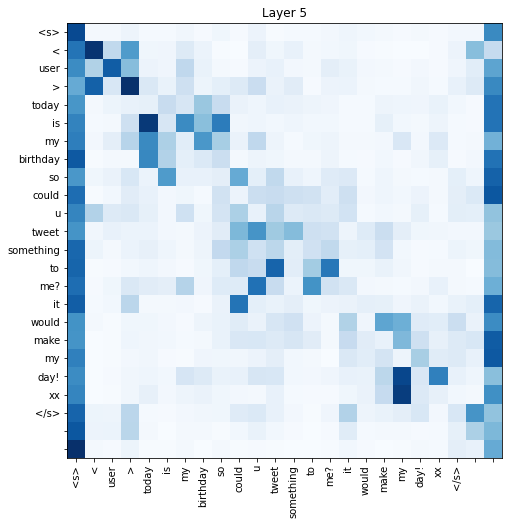

In [12]:
def plot_layer(attns, ind=0, layer=0):
    plt.figure(figsize=(8, 8))
    text = tokenizer.decode(input_ids[ind])
    # may not be correct as tokenizing is not fully reversible
    
    num_word = torch.sum(input_ids[ind]!=1).numpy()
    attn = np.moveaxis(attns[layer][ind].detach().numpy(), 0, -1)
    attn = np.max(attn, axis=-1)
    attn = attn[:num_word, :num_word]
    plt.imshow(attn, cmap='Blues', interpolation='none')
    ax = plt.gca()
    ax.set_title('Layer {}'.format(layer+1))
    ax.set_xticks(np.arange(0, num_word, 1))
    ax.set_yticks(np.arange(0, num_word, 1))
    
    text = re.sub('</s>', ' </s>', text)
    id_ = text.index('<pad>')
    text = text[:id_].split()
    print ('Text: ', ' '.join(text[:num_word]))
    ax.set_xticklabels(text[:num_word], rotation='vertical')
    ax.set_yticklabels(text[:num_word])

plot_layer(attns, 1, layer=4)

### Plot Number of Heads attending to Special Tokens

In [13]:
total = []

for ind in range(0, 63):
    num_word = torch.sum(input_ids[ind]!=1).numpy()
    
    num_heads = []
    for i in range(NUM_LAYERS):
        cls_attending_heads = 0
        for j in range(NUM_HEADS):
            attn = np.moveaxis(attns[i][ind].detach().numpy(), 0, -1)[:, :, j]
            temp = np.sum(attn[:, 0]>0.5)
            if temp/num_word > 0.75:
                cls_attending_heads += 1
        num_heads.append(cls_attending_heads)
    total.append(num_heads)
    
total = np.array(total)
total = np.mean(total, axis=0)

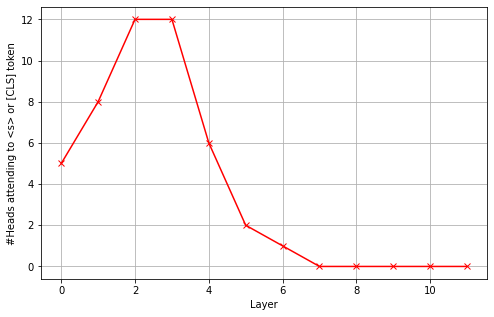

In [14]:
plt.figure(figsize=(8, 5))
plt.plot(num_heads, marker='x', color='red')
plt.xlabel('Layer')
plt.ylabel('#Heads attending to <s> or [CLS] token')
plt.grid()